<a href="https://colab.research.google.com/github/Hadiasemi/Data301/blob/main/Copy_of_5_6_Model_Selection_and_Hyperparameter_Tuning_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.6 Model Selection and Hyperparameter Tuning

In this lesson, we will use the tools developed in the previous section to answer two important questions:

- Model Selection: Is $k$-nearest neighbors better or is linear regression better? Which features should we include in the model?
- Hyperparameter Tuning: How do we choose hyperparameters, such as $k$ in $k$-nearest neighbors?

In the previous lesson, we saw how to use cross-validation to estimate how well a model will perform on test data. A natural way to decide between competing models or hyperparameters is to choose the one that minimizes the validation error.

In [ ]:
import pandas as pd
import numpy as np

# Extract the training data.
data_dir = "https://dlsun.github.io/pods/data/"
bordeaux_df = pd.read_csv(data_dir + "bordeaux.csv",
                          index_col="year")
bordeaux_train = bordeaux_df.loc[:1980].copy()
bordeaux_train["log(price)"] = np.log(bordeaux_train["price"])

## Model Selection

Suppose we wish to fit a $4$-nearest neighbors model but are not sure which features to include in the model. In the code below, we consider five possible sets of features.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# calculate estimate of test error for a given feature set
def get_cv_error(features):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=4)
  )
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=bordeaux_train[features], 
                             y=bordeaux_train["log(price)"],
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [["win", "summer"],
                 ["win", "summer", "age"],
                 ["win", "summer", "age", "sep"],
                 ["win", "summer", "age", "har"],
                 ["win", "summer", "age", "har", "sep"]]:
  errs[str(features)] = get_cv_error(features)

errs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


['win', 'summer']                         0.229951
['win', 'summer', 'age']                  0.240647
['win', 'summer', 'age', 'sep']           0.275654
['win', 'summer', 'age', 'har']           0.175315
['win', 'summer', 'age', 'har', 'sep']    0.254417
dtype: float64

Notice that more is not necessarily better. The model with the lowest mean-squared error is actually the one with four features:

- winter rainfall (**win**)
- average summer temperature (**summer**)
- age of the wine (**age**)
- harvest rainfall (**har**)

The mean-squared error actually increases when we add the average September temperature (**sep**) to the model.

## Hyperparameter Tuning

Now that we have a good working model, how do we determine the optimal value of the hyperparameter $k$? We can use cross-validation to estimate the test error for different values of $k$ and choose the one with the smallest (test) MSE. This is not hard to do manually.

3     0.174962
4     0.175315
5     0.198948
9     0.199141
8     0.210195
2     0.213024
10    0.214402
6     0.220198
7     0.228192
11    0.237055
12    0.252668
1     0.254797
13    0.256685
14    0.264675
15    0.270900
16    0.276364
17    0.281160
18    0.285790
19    0.301274
dtype: float64

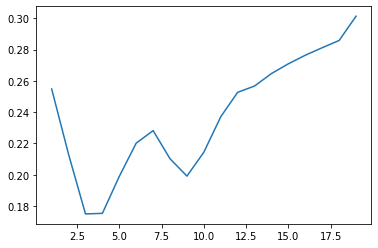

In [ ]:
X_train = bordeaux_train[["win", "summer", "age", "har"]]
y_train = bordeaux_train["log(price)"]

# calculate estimate of test error for a value of k
def get_cv_error(k):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k)
  ) 
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()
    
ks = pd.Series(range(1, 20))
ks.index = range(1, 20)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values()

The MSE is minimized at $k = 3$, which suggests that we should use a $3$-nearest neighbors model to predict wine quality.

Scikit-learn provides a utility, `GridSearchCV`, that automates most of the drudgery of trying different hyperparameters. We specify `param_grid=`, which is a dictionary that maps the name of the parameter (e.g., `n_neighbors`) to a list of parameter values to try. The model with the highest score will be stored in `.best_estimator_`. (Note the trailing underscore, which indicates that this attribute is only available after `.fit()` has been called.)

For simplicity, let's start by fitting $k$-nearest neighbors to the raw data directly, without standardization.

In [ ]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsRegressor(n_neighbors=5)

# GridSearchCV will replace n_neighbors by values in param_grid.
grid_search = GridSearchCV(model,
                           param_grid={"n_neighbors": range(1, 20)},
                           scoring="neg_mean_squared_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

KNeighborsRegressor(n_neighbors=9)

More realistically, we will want to standardize the feature variables before passing them into `KNeighborsRegressor`, so we set up a pipeline. Notice that each step in the pipeline is automatically given a name. We will need to refer to this name when using `GridSearchCV`.

In [ ]:
# define pipeline
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5)
) 
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

The parameter that we want to tune is `n_neighbors`, which is embedded inside the `kneighborsregressor` step of the pipeline. In `GridSearchCV`, the convention is to refer to a parameter inside a step of the pipeline as `<step>__<parameter>`. So the parameter we are tuning in this case is `kneighborsregressor__n_neighbors`.

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_squared_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=3))])

Inspecting the scikit-learn model that was deemed best by `GridSearchCV`, we see that a $3$-nearest neighbors model has the lowest MSE, which agrees with what we obtained earlier. It is possible to get a complete summary of what `GridSearchCV` tried, in the attribute `.cv_results_`.

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([0.01132772, 0.01867335, 0.0098773 , 0.01054583, 0.01318598,
        0.01217456, 0.0171905 , 0.01253765, 0.01129906, 0.00877204,
        0.00963748, 0.0128675 , 0.00939014, 0.0131963 , 0.01343427,
        0.01441777, 0.02074919, 0.01723976, 0.00972297]),
 'mean_score_time': array([0.00522866, 0.00930941, 0.00592918, 0.00559411, 0.00549328,
        0.0059006 , 0.00931695, 0.00891943, 0.00547988, 0.00505857,
        0.00613673, 0.0076833 , 0.00538576, 0.00628588, 0.0066767 ,
        0.0063138 , 0.00713258, 0.00859604, 0.00521321]),
 'mean_test_score': array([-0.25479653, -0.21302425, -0.17496234, -0.17531468, -0.19894827,
        -0.22019751, -0.22819183, -0.21019534, -0.19914083, -0.21440248,
        -0.23705541, -0.25266814, -0.25668508, -0.26467454, -0.27090046,
        -0.27636402, -0.28116019, -0.28578995, -0.30127447]),
 'param_kneighborsregressor__n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17,

## Exercises

1\. Train a linear regression model on the Ames data (http://dlsun.github.io/pods/data/AmesHousing.txt ) that predicts the sale price using the square footage (**Gr Liv Area**), number of bedrooms (**Bedrooms AbvGr**), and neighborhood (**Neighborhood**). Decide whether it would be valuable to add the number of full bathrooms (**Full Bath**) and/or the number of half bathrooms (**Half Bath**) to this model.

In [ ]:
df_housing = pd.read_csv('http://dlsun.github.io/pods/data/AmesHousing.txt',delimiter='\t')
df_housing['LogSalePrice'] = np.log(df_housing['SalePrice'])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# calculate estimate of test error for a given feature set
def get_cv_error(features):

  ct = make_column_transformer(
      (StandardScaler(), features),
      (OneHotEncoder(handle_unknown='ignore'), ["Neighborhood"]),
      remainder="drop"  # all other columns in X will be dropped.
  )

  pipeline = make_pipeline(
    ct,
    LinearRegression()
  )
  
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=df_housing[features + ['Neighborhood']],
                             y=df_housing["LogSalePrice"],
                             scoring="neg_mean_squared_error", cv=10)
  
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [["Gr Liv Area", "Bedroom AbvGr"],
                 ["Gr Liv Area", "Bedroom AbvGr", "Full Bath"],
                 ["Gr Liv Area", "Bedroom AbvGr", "Half Bath"],
                 ["Gr Liv Area", "Bedroom AbvGr", "Full Bath", "Half Bath"]]:
  errs[str(features)] = get_cv_error(features)

errs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


['Gr Liv Area', 'Bedroom AbvGr']                              0.041325
['Gr Liv Area', 'Bedroom AbvGr', 'Full Bath']                 0.041321
['Gr Liv Area', 'Bedroom AbvGr', 'Half Bath']                 0.041277
['Gr Liv Area', 'Bedroom AbvGr', 'Full Bath', 'Half Bath']    0.041345
dtype: float64

2\. Train a $k$-nearest neighbors model on the tips data (http://dlsun.github.io/pods/data/tips.csv ). Use cross-validation to determine the optimal value of $k$.

In [ ]:
df_tips = pd.read_csv('http://dlsun.github.io/pods/data/tips.csv')
df_tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [ ]:
ct = make_column_transformer(
    (OneHotEncoder(), ["sex", 'day']),
    (StandardScaler(), ['total_bill','size']),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor()
)

X_train = df_tips[['total_bill','size','sex','day']]
y_train = df_tips['tip']

In [ ]:
grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_absolute_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'day']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['total_bill', 'size'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=10))])